No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
C:\Users\nel_t\AppData\Local\Temp\ipykernel_13560\3375466804.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


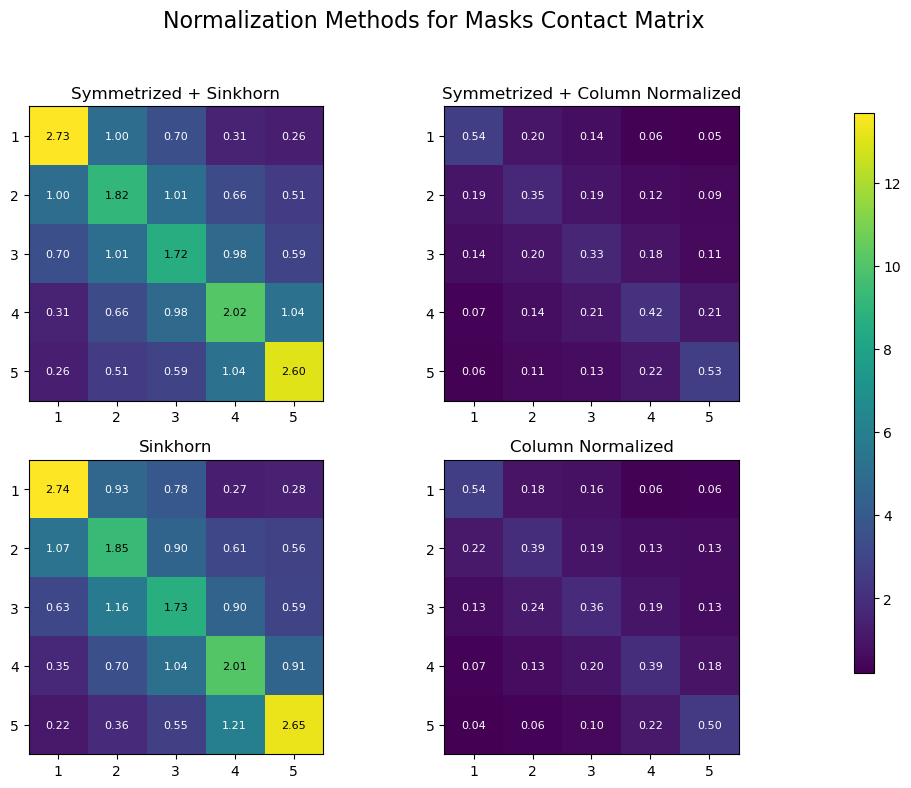

C:\Users\nel_t\AppData\Local\Temp\ipykernel_13560\3375466804.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


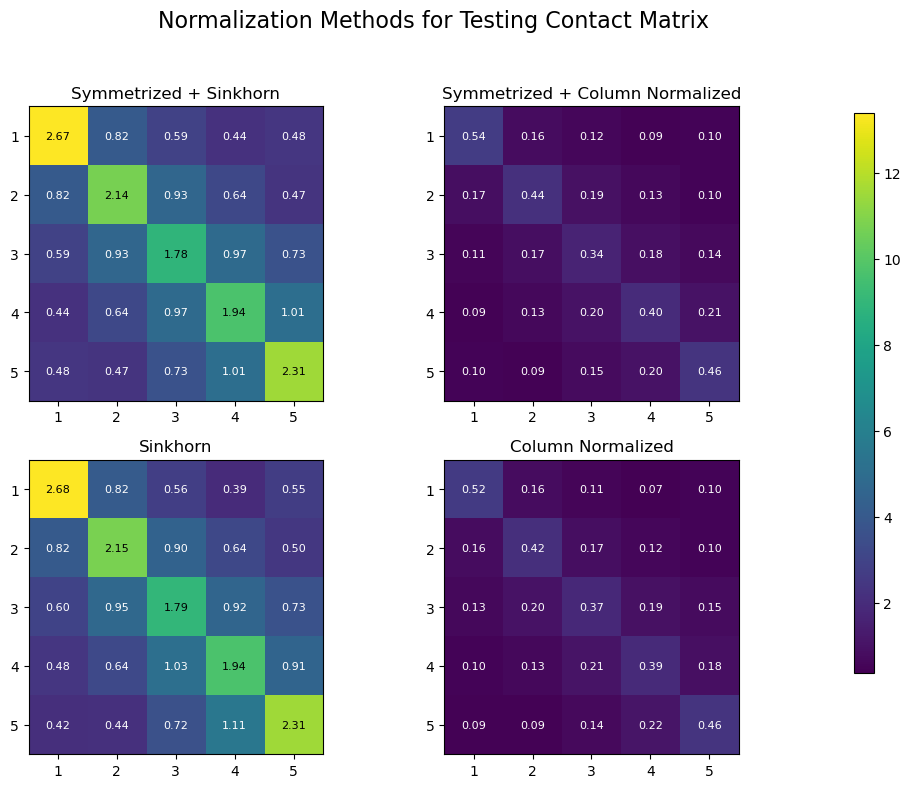

C:\Users\nel_t\AppData\Local\Temp\ipykernel_13560\3375466804.py:183: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


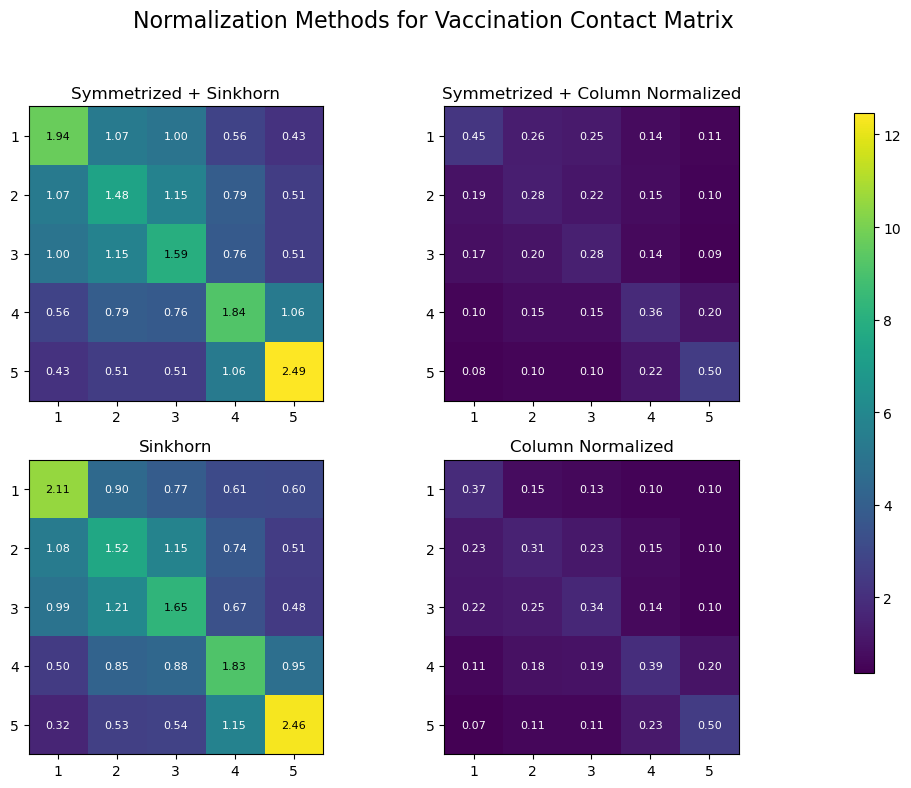

In [ ]:
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List
from src.utils.Contact_Matrix import matrix_scaling
from src.utils.Contact_Matrix import create_contact_matrix

def generate_matrices_with_normalizations(
    df: pd.DataFrame,
    behavior_type: str,
    normalizations: List[str]
) -> Dict[str, jnp.ndarray]:
    """
    Generate contact matrices with different normalization methods.
    
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        normalizations: List of normalization methods to apply
        
    Returns:
        Dictionary of matrices with different normalizations
    """
    normalized_matrices = {}
    n_bins = 5
    
    # Clean data
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
    
    # Generate raw contact matrix
    contact_matrix = np.zeros((n_bins, n_bins))
    
    # Define columns based on behavior type
    if behavior_type == "vacc":
        cols = [f'{behavior_type}_others0{i+1}' for i in range(n_bins)]
    else:
        cols = [
            f'{behavior_type}_others_never', 
            f'{behavior_type}_others_sometimes',
            f'{behavior_type}_others_half',
            f'{behavior_type}_others_often',
            f'{behavior_type}_others_always'
        ]
    
    # Fill contact matrix
    for i, row in df_clean.iterrows():
        self_idx = int(row[f'{behavior_type}_self']) - 1
        for j, col in enumerate(cols):
            if pd.notna(row[col]):
                contact_matrix[self_idx, j] += row[col]
    
    # Apply different normalizations
    for norm_method in normalizations:
        if norm_method == "raw":
            # Store raw matrix without normalization
            normalized_matrices["raw"] = jnp.array(contact_matrix)
            continue
            
        # Step 1: Normalize by row counts (common first step)
        raw_normalized = np.zeros_like(contact_matrix)
        for i in range(n_bins):
            group_count = np.sum(self_behavior == i+1)
            if group_count > 0:
                raw_normalized[i, :] = contact_matrix[i, :] / group_count
        
        # Apply specific normalization method
        if norm_method == "column_normalized":
            # Normalize each column to sum to 1
            col_sums = raw_normalized.sum(axis=0)
            col_normalized = raw_normalized.copy()
            for j in range(n_bins):
                if col_sums[j] > 0:
                    col_normalized[:, j] = raw_normalized[:, j] / col_sums[j]
            normalized_matrices[norm_method] = jnp.array(col_normalized) * n_bins
            
        elif norm_method == "symmetrized_column_normalized":
            # First symmetrize
            symmetrized = 0.5 * (raw_normalized + raw_normalized.T)
            # Then normalize by column
            col_sums = symmetrized.sum(axis=0)
            sym_col_normalized = symmetrized.copy()
            for j in range(n_bins):
                if col_sums[j] > 0:
                    sym_col_normalized[:, j] = symmetrized[:, j] / col_sums[j]
            normalized_matrices[norm_method] = jnp.array(sym_col_normalized) * n_bins
            
        elif norm_method == "sinkhorn":
            # Apply Sinkhorn normalization
            raw_normalized_jax = jnp.array(raw_normalized)
            sinkhorn_normalized, _, _ = matrix_scaling(raw_normalized_jax)
            normalized_matrices[norm_method] = sinkhorn_normalized * (n_bins**2)
            
        elif norm_method == "symmetrized_sinkhorn":
            # First symmetrize
            symmetrized = 0.5 * (raw_normalized + raw_normalized.T)
            # Apply Sinkhorn normalization
            symmetrized_jax = jnp.array(symmetrized)
            sinkhorn_normalized, _, _ = matrix_scaling(symmetrized_jax)
            # Re-symmetrize after Sinkhorn to ensure symmetry
            final_symmetric = 0.5 * (sinkhorn_normalized + sinkhorn_normalized.T)
            normalized_matrices[norm_method] = final_symmetric * (n_bins**2)
    
    return normalized_matrices

def visualize_normalizations(
    df: pd.DataFrame,
    behavior_types: List[str] = ["masks", "testing", "vacc"],
    save_path: str = None
):
    """
    Visualize the impact of different normalization methods on contact matrices.
    """
    normalizations = [
        "symmetrized_sinkhorn",
        "symmetrized_column_normalized",
        "sinkhorn",
        "column_normalized"
    ]
    
    norm_labels = {
        "symmetrized_sinkhorn": "Symmetrized + Sinkhorn",
        "symmetrized_column_normalized": "Symmetrized + Column Normalized",
        "sinkhorn": "Sinkhorn",
        "column_normalized": "Column Normalized"
    }
    
    behavior_labels = {
        "masks": "Masks",
        "testing": "Testing",
        "vacc": "Vaccination"
    }
    
    # Create a figure for each behavior type
    for behavior_type in behavior_types:
        # Generate matrices with different normalizations
        matrices = generate_matrices_with_normalizations(df, behavior_type, normalizations)
        
        # Find global min/max for consistent colorbar
        all_values = np.concatenate([np.array(matrices[norm]).flatten() for norm in normalizations])
        vmin, vmax = np.min(all_values), np.max(all_values)
        
        # Create figure with subplots
        fig, axes = plt.subplots(2, 2, figsize=(10, 8))
        axes = axes.flatten()
        
        # Plot each normalization method
        for i, norm_method in enumerate(normalizations):
            ax = axes[i]
            matrix = np.array(matrices[norm_method])
            
            im = ax.imshow(matrix, cmap='viridis', vmin=vmin, vmax=vmax)
            ax.set_title(norm_labels[norm_method])
            ax.set_xticks(range(5))
            ax.set_yticks(range(5))
            ax.set_xticklabels(range(1, 6))
            ax.set_yticklabels(range(1, 6))
            
            # Add text with the value in each cell
            for y in range(matrix.shape[0]):
                for x in range(matrix.shape[1]):
                    # Format value to 2 decimal places
                    value = matrix[y, x]/5
                    text = f"{value:.2f}" if value != 0 else "0"
                    
                    # Determine text color based on background darkness
                    # Darker backgrounds get white text, lighter get black text
                    color_val = (value - vmin) / (vmax - vmin)
                    text_color = 'black' if color_val > 0.5/5 else 'white'
                    
                    # Add text to cell
                    ax.text(x, y, text, ha='center', va='center', 
                           color=text_color, fontsize=8)
            
        # Add colorbar
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(im, cax=cbar_ax)
        
        # Set overall title
        fig.suptitle(f"Normalization Methods for {behavior_labels[behavior_type]} Contact Matrix", fontsize=16)
        plt.tight_layout(rect=[0, 0, 0.9, 0.95])
        
        if save_path:
            plt.savefig(f"{save_path}/{behavior_type}_normalization_comparison.png", dpi=300, bbox_inches='tight')
            
        plt.show()




import numpy as np
import matplotlib.pyplot as plt

def plot_contact_matrix(matrix, ax=None, title=None, cmap='viridis', figsize=(6, 5), save_path=None):
    """
    Plot a contact matrix as a heatmap with values displayed in each cell.
    
    Args:
        matrix: 5x5 numpy array to visualize
        ax: Matplotlib axis to plot on (if None, creates a new figure)
        title: Optional title for the plot
        cmap: Colormap to use
        figsize: Figure size as (width, height) - only used if ax is None
        save_path: Path to save the figure (if None, figure is not saved)
        
    Returns:
        The matplotlib axis object with the plot
    """
    # Create figure if ax not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    # Plot heatmap
    im = ax.imshow(matrix, cmap=cmap)
    
    # Add colorbar
    #plt.colorbar(im, ax=ax)
    
    # Set ticks
    ax.set_xticks(range(5))
    ax.set_xticklabels(range(1, 6))
    ax.set_yticks(range(5))
    ax.set_yticklabels(range(1, 6))
    
    # Add title if provided
    if title:
        ax.set_title(title)
    
    # Add text with the value in each cell
    for i in range(5):
        for j in range(5):
            # Format value to 2 decimal places
            value = matrix[i, j]
            text = f"{value:.2f}" if value != 0 else "0"
            
            # Determine text color based on background darkness
            color_val = (value - np.min(matrix)) / (np.max(matrix) - np.min(matrix) + 1e-8)
            text_color = 'black' if color_val > 0.5 else 'white'
            
            # Add text to cell
            ax.text(j, i, text, ha='center', va='center', 
                   color=text_color, fontsize=9)
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return ax



def extract_behavior_distribution(df, behavior_type):
    """
    Extract behavior distribution from raw CSV data.
    
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        
    Returns:
        Normalized behavior distribution as a numpy array
    """
    # Clean data
    df_clean = df.dropna(subset=[f'{behavior_type}_self'])
    
    # Extract self-reported behavior
    self_behavior = df_clean[f'{behavior_type}_self'].astype(int)
    
    # Count occurrences of each behavior level (1-5)
    n_bins = 5
    behavior_vector = np.zeros(n_bins)
    for i in range(n_bins):
        behavior_vector[i] = np.sum(self_behavior == i+1)
    
    # Normalize to get distribution
    behavior_vector = behavior_vector / np.sum(behavior_vector)
    
    return behavior_vector

def plot_behavior_distribution(df, behavior_type, title=None, figsize=(6, 5), color='steelblue', save_path=None):
    """
    Extract and plot behavior distribution from raw CSV data.
    
    Args:
        df: DataFrame with survey data
        behavior_type: Type of behavior ("masks", "testing", or "vacc")
        title: Optional title for the plot
        figsize: Figure size as (width, height)
        color: Bar color
        save_path: Path to save the figure (if None, figure is not saved)
        
    Returns:
        The behavior distribution vector
    """
    # Extract behavior distribution
    behavior_vector = extract_behavior_distribution(df, behavior_type)
    
    # Create figure
    plt.figure(figsize=figsize)
    
    # Plot histogram as bars
    plt.bar(range(1, len(behavior_vector)+1), behavior_vector, color=color)
    
    # Set x-axis ticks
    plt.xticks(range(1, len(behavior_vector)+1))
    
    # Add title if provided
    if title:
        plt.title(title)
    else:
        behavior_labels = {
            "masks": "Masks",
            "testing": "Testing",
            "vacc": "Vaccination"
        }
        plt.title(f"{behavior_labels.get(behavior_type, behavior_type)} Behavior Distribution")
    
    # Add text with the value on top of each bar
    for i, value in enumerate(behavior_vector):
        # Format value to 3 decimal places
        text = f"{value:.3f}"
        
        # Add text above each bar
        plt.text(i+1, value + 0.01, text, ha='center', va='bottom', fontsize=9)
    
    # Save figure if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return behavior_vector


# Load the data
csv_path = 'data_homophily.csv'
df = pd.read_csv(csv_path)
df_current = df_current.dropna()  # Drops rows with any NaN values

# Visualize normalizations for each behavior type
visualize_normalizations(df, save_path="./figures")

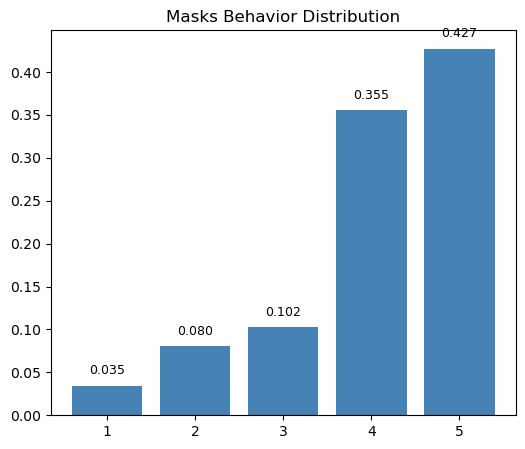

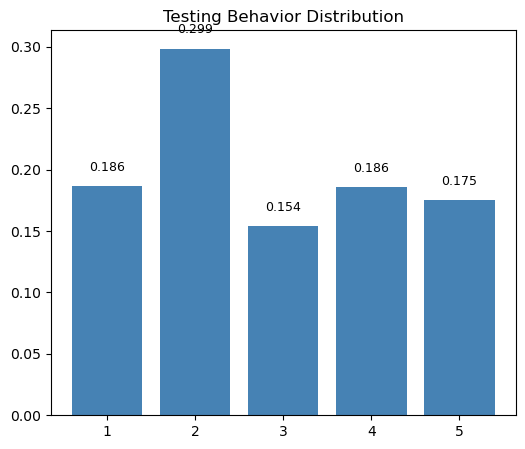

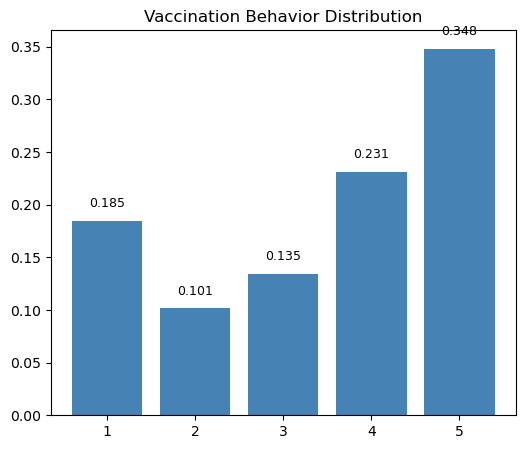

Masks distribution: [0.03462604 0.08033241 0.10249307 0.35526316 0.42728532]
Testing distribution: [0.18635171 0.29855643 0.15419948 0.18569554 0.17519685]
Vaccination distribution: [0.18458418 0.10141988 0.13455037 0.23123732 0.34820825]


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Load the data
csv_path = 'data_homophily.csv'
df = pd.read_csv(csv_path)

# Extract and plot behavior distributions
masks_distribution = extract_behavior_distribution(df, "masks")
testing_distribution = extract_behavior_distribution(df, "testing")
vacc_distribution = extract_behavior_distribution(df, "vacc")


MHIST = plot_behavior_distribution(df, "masks", save_path="masks_distribution.png")
THIST = plot_behavior_distribution(df, "testing", save_path="testing_distribution.png")
VHIST = plot_behavior_distribution(df, "vacc", save_path="vacc_distribution.png")

print("Masks distribution:", MHIST)
print("Testing distribution:", THIST)
print("Vaccination distribution:", VHIST)

In [118]:
masks_distribution

array([0.03462604, 0.08033241, 0.10249307, 0.35526316, 0.42728532])

In [ ]:
M0 = np.array(generate_matrices_with_normalizations(df, "masks", ["raw"])["raw"])
T0 = np.array(generate_matrices_with_normalizations(df, "testing", ["raw"])["raw"])
V0 = np.array(generate_matrices_with_normalizations(df, "vacc", ["raw"])["raw"])

# symmetrize the matrices

# normalize by population

M1 = (M0.T/masks_distribution).T
T1 = (T0.T/testing_distribution).T
V1 = (V0.T/vacc_distribution).T


M2 = 0.5 * (M1 + M1.T)
T2 = 0.5 * (T1 + T1.T)
V2 = 0.5 * (V1 + V1.T)


# sinkhorn the matrices
from src.utils.Contact_Matrix import matrix_scaling

M_S2, _, _ = matrix_scaling(M2, max_iters=5000, threshold=1e-8)
T_S2, _, _ = matrix_scaling(T2, max_iters=5000, threshold=1e-8)
V_S2, _, _ = matrix_scaling(V2, max_iters=5000, threshold=1e-8)

M_S2 = M_S2 * 5
T_S2 = T_S2 * 5
V_S2 = V_S2 * 5

print(np.sum(M_S2, axis=0))
print(np.sum(M_S2, axis=1))


[1.        1.        0.9999999 1.        1.       ]
[1.         1.         1.         1.         0.99999994]


In [101]:
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

n_groups = 5


def my_beta_populations(a=2.0, b=2.0, n=n_groups, norm=1.0):
    """Generate population sizes based on beta distribution"""
    x = jnp.linspace(1/n/2, 1-1/n/2, n)
    from jax.scipy.stats import beta as jbeta
    y = jbeta.pdf(x, a, b)
    return y / jnp.sum(y) * norm

In [ ]:

C = create_contact_matrix(5, 2)

plot_contact_matrix(C)
print(np.max(np.abs(1-np.sum(C, axis=0))))
print(np.max(np.abs(1-np.sum(C, axis=1))))


TypeError: create_contact_matrix() missing 1 required positional argument: 'populations'

0.0
0.020950913


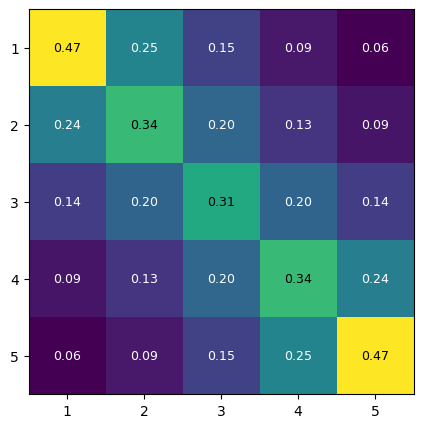

In [137]:
C = create_contact_matrix_test(n_groups, 2)
plot_contact_matrix(C)
print(np.max(np.abs(1-np.sum(C, axis=0))))
print(np.max(np.abs(1-np.sum(C, axis=1))))

<Axes: >

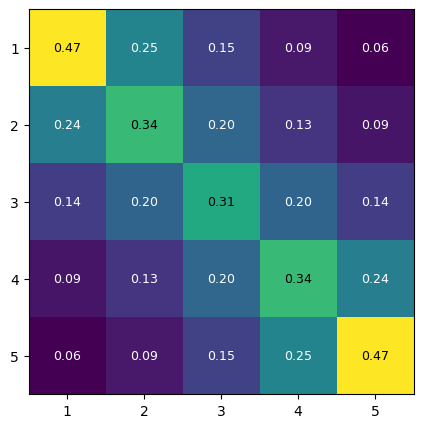

In [ ]:
C = create_contact_matrix_test(n_groups, 2)
plot_contact_matrix(C)
print(np.sum(C, axis=0))
print(np.sum(C, axis=1))

[ 13.005291 471.26358  988.7126   471.2638    13.005302]
[0.93295056 1.0402061  1.0536869  1.0402061  0.9329505 ]
[0.99999994 1.         1.0000001  1.         1.        ]


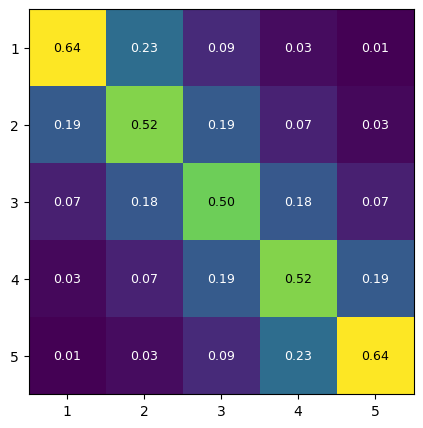

In [115]:
h = 4
populations = my_beta_populations(a=5, b=5.0, norm=1000)
positions = jnp.linspace(0, 1, n_groups)
diffs = jnp.abs(positions[:, None] - positions[None, :])
W = jnp.exp(-h * diffs)

# For each column j, normalize by sum of weighted populations
# This ensures each column sums to 1 (total probability = 1)

V = jnp.sum(W * populations[None, :], axis=0)
print(V)
C = (W.T / V).T

C = (C.T/np.sum(C.T, axis=0)).T
#C = (weights * populations[None, :]) / jnp.sum(weights * populations[None, :], axis=0)[None, :]
#C = weights / jnp.sum(weights, axis=0)[None, :]


plot_contact_matrix(C)
print(np.sum(C, axis=0))
print(np.sum(C, axis=1))

In [ ]:
def my_beta_populations(a=2.0, b=2.0, n=n_groups, norm=1.0):
    """Generate population sizes based on beta distribution"""
    x = jnp.linspace(1/n/2, 1-1/n/2, n)
    from jax.scipy.stats import beta as jbeta
    y = jbeta.pdf(x, a, b)
    return y / jnp.sum(y) * norm

In [ ]:

# plot the matrices

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
plot_contact_matrix(M_S2, ax=axes[0], title="Masks Symmetrized + Sinkhorn")
plot_contact_matrix(T_S2, ax=axes[1], title="Testing Symmetrized + Sinkhorn")
plot_contact_matrix(V_S2, ax=axes[2], title="Vaccination Symmetrized + Sinkhorn")


Text(0.5, 0.98, 'Contact Matrix normalized by population and row')

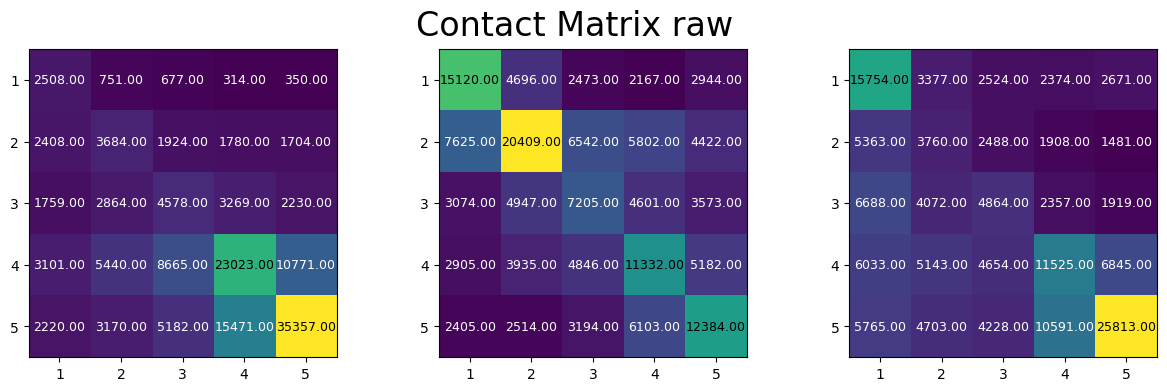

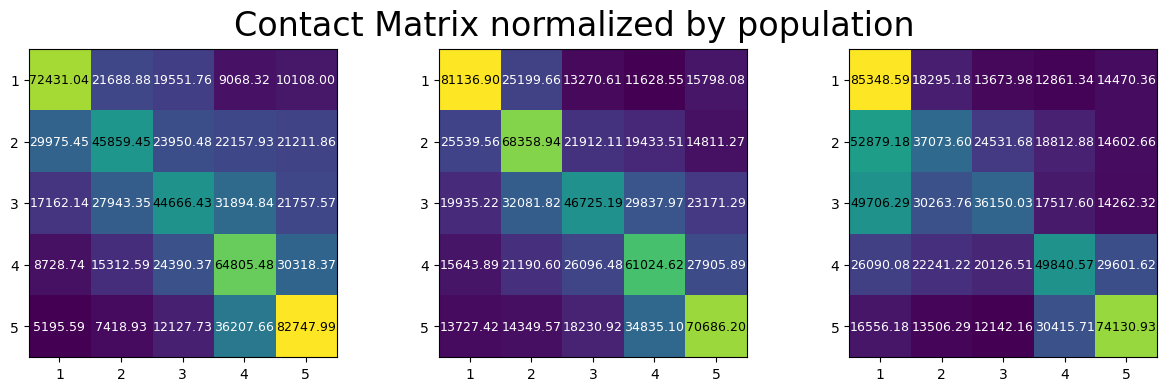

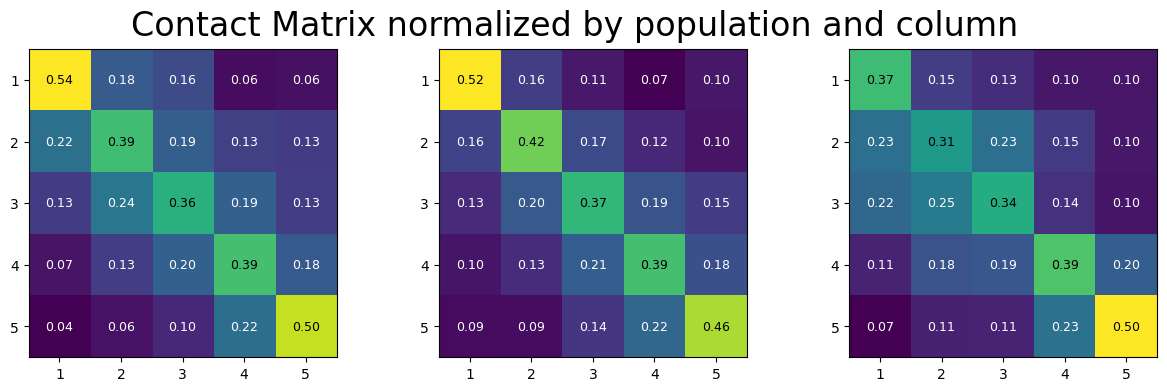

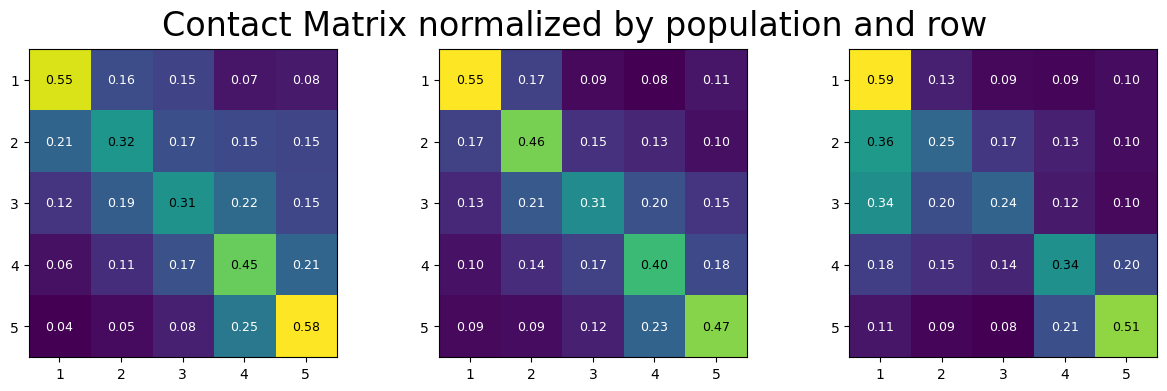

In [72]:
llx = 15
lly = 4

fig, ax = plt.subplots(1, 3, figsize=(llx, lly))
plot_contact_matrix(mask_raw_matrix, ax=ax[0])
plot_contact_matrix(test_raw_matrix, ax=ax[1])
plot_contact_matrix(vacc_raw_matrix, ax=ax[2])

fig.suptitle("Contact Matrix raw", fontsize=24)

fig, ax = plt.subplots(1, 3, figsize=(llx, lly))
M0 = (mask_raw_matrix.T/masks_distribution).T
T0 = (test_raw_matrix.T/testing_distribution).T
V0 = (vacc_raw_matrix.T/vacc_distribution).T
plot_contact_matrix(M0, ax=ax[0])
plot_contact_matrix(T0, ax=ax[1])
plot_contact_matrix(V0, ax=ax[2])

fig.suptitle("Contact Matrix normalized by population", fontsize=24)




M1 = M0.copy()
T1 = T0.copy()
V1 = V0.copy()

M1 = M1 / np.sum(M1, axis=0)
T1 = T1 / np.sum(T1, axis=0)
V1 = V1 / np.sum(V1, axis=0)

fig, ax = plt.subplots(1, 3, figsize=(llx, lly))
plot_contact_matrix(M1, ax=ax[0])
plot_contact_matrix(T1, ax=ax[1])
plot_contact_matrix(V1, ax=ax[2])

fig.suptitle("Contact Matrix normalized by population and column", fontsize=24)





M1_R = M0 / np.sum(M0, axis=1)[:, np.newaxis]
T1_R = T0 / np.sum(T0, axis=1)[:, np.newaxis]
V1_R = V0 / np.sum(V0, axis=1)[:, np.newaxis]


fig, ax = plt.subplots(1, 3, figsize=(llx, lly))

plot_contact_matrix(M1_R, ax=ax[0])
plot_contact_matrix(T1_R, ax=ax[1])
plot_contact_matrix(V1_R, ax=ax[2])

fig.suptitle("Contact Matrix normalized by population and row", fontsize=24)











Text(0.5, 0.98, 'Contact Matrix symmetrized and normalized by population and row')

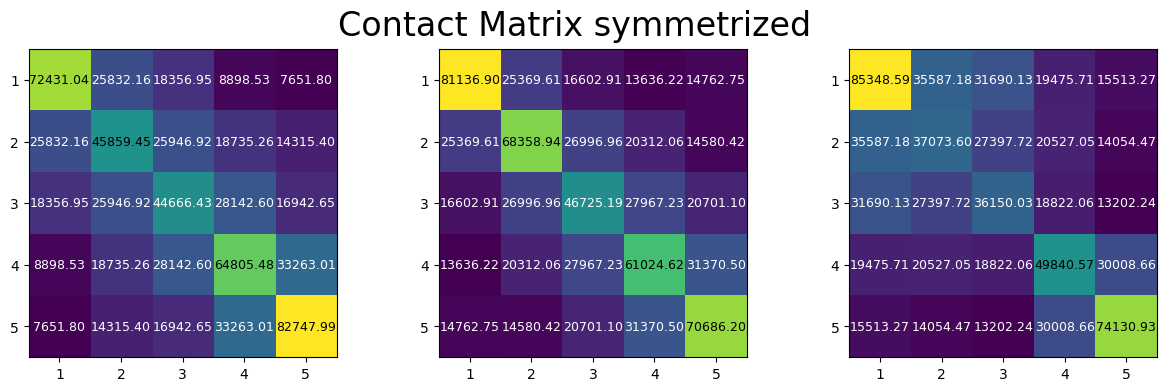

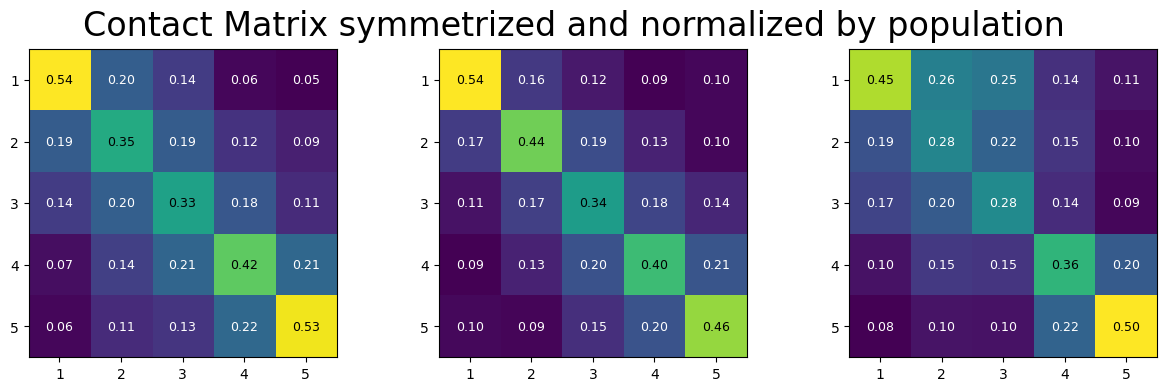

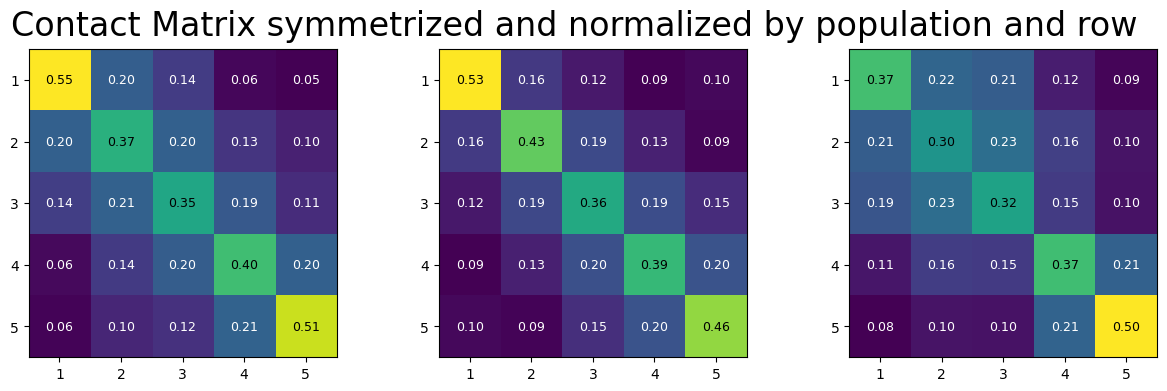

In [73]:
# now repeat with the symmetrized versions

M2 = (mask_raw_matrix.T/masks_distribution).T
T2 = (test_raw_matrix.T/testing_distribution).T
V2 = (vacc_raw_matrix.T/vacc_distribution).T

M2 = 0.5 * (M2 + M2.T)
T2 = 0.5 * (T2 + T2.T)
V2 = 0.5 * (V2 + V2.T)



fig, ax = plt.subplots(1, 3, figsize=(llx, lly))
plot_contact_matrix(M2, ax=ax[0])
plot_contact_matrix(T2, ax=ax[1])
plot_contact_matrix(V2, ax=ax[2])

fig.suptitle("Contact Matrix symmetrized", fontsize=24)
M2 = M2 / np.sum(M2, axis=0)
T2 = T2 / np.sum(T2, axis=0)
V2 = V2 / np.sum(V2, axis=0)



fig, ax = plt.subplots(1, 3, figsize=(llx, lly))

plot_contact_matrix(M2, ax=ax[0])
plot_contact_matrix(T2, ax=ax[1])
plot_contact_matrix(V2, ax=ax[2])

fig.suptitle("Contact Matrix symmetrized and normalized by population", fontsize=24)

M2_R = M2 / np.sum(M2, axis=1)[:, np.newaxis]
T2_R = T2 / np.sum(T2, axis=1)[:, np.newaxis]
V2_R = V2 / np.sum(V2, axis=1)[:, np.newaxis]



fig, ax = plt.subplots(1, 3, figsize=(llx, lly))

plot_contact_matrix(M2_R, ax=ax[0])
plot_contact_matrix(T2_R, ax=ax[1])
plot_contact_matrix(V2_R, ax=ax[2])

fig.suptitle("Contact Matrix symmetrized and normalized by population and row", fontsize=24)

0.11035459
0.106739245
0.099742286
_____
0.0017216764
0.0007259287
0.0027149245


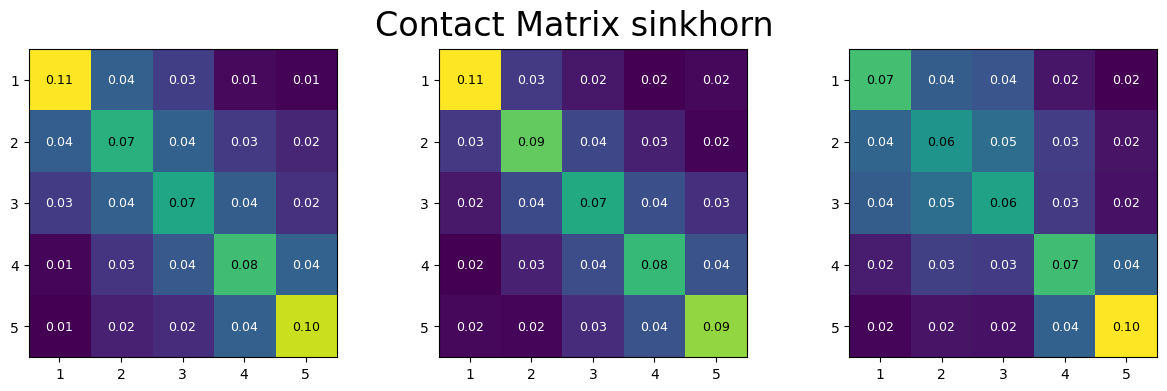

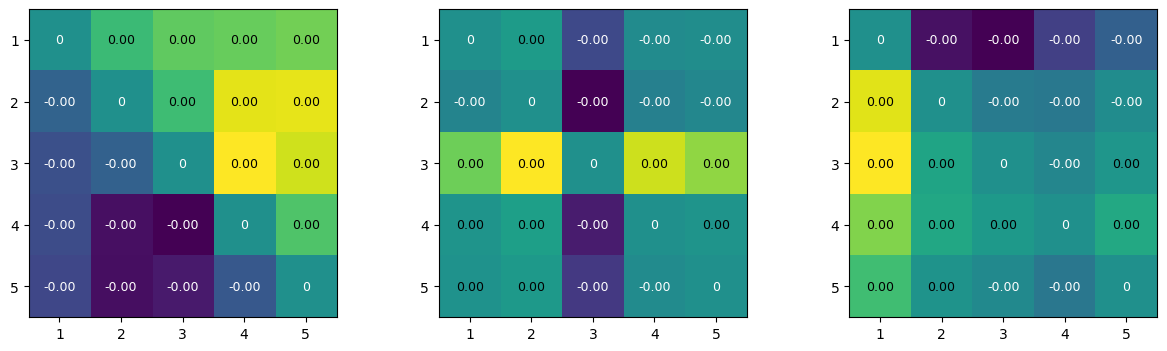

In [84]:
# now repeat with the sinkhorn versions

M3 = (mask_raw_matrix.T/masks_distribution).T
T3 = (test_raw_matrix.T/testing_distribution).T
V3 = (vacc_raw_matrix.T/vacc_distribution).T


# symmetrize the data:

M3 = 0.5 * (M3 + M3.T)
T3 = 0.5 * (T3 + T3.T)
V3 = 0.5 * (V3 + V3.T)


M3, _, _ = matrix_scaling(M3)
T3, _, _ = matrix_scaling(T3)
V3, _, _ = matrix_scaling(V3)

fig, ax = plt.subplots(1, 3, figsize=(llx, lly))
plot_contact_matrix(M3, ax=ax[0])
plot_contact_matrix(T3, ax=ax[1])
plot_contact_matrix(V3, ax=ax[2])
fig.suptitle("Contact Matrix sinkhorn", fontsize=24)


print(np.max(np.abs(M3)))
print(np.max(np.abs(T3)))
print(np.max(np.abs(V3)))
print("_____")


# check how asymmetric the sinkhorn matrix is
M3_R = M3 - M3.T
T3_R = T3 - T3.T
V3_R = V3 - V3.T

fig, ax = plt.subplots(1, 3, figsize=(llx, lly))

plot_contact_matrix(M3_R, ax=ax[0])
plot_contact_matrix(T3_R, ax=ax[1])
plot_contact_matrix(V3_R, ax=ax[2])

print(np.max(np.abs(M3_R)))
print(np.max(np.abs(T3_R)))
print(np.max(np.abs(V3_R)))




In [ ]:
# check how asymmetric the sinkhorn matrix is
M3_R = M3 - M3.T
T3_R = T3 - T3.T
V3_R = V3 - V3.T

fig, ax = plt.subplots(1, 3, figsize=(llx, lly))

plot_contact_matrix(M3_R, ax=ax[0])
plot_contact_matrix(T3_R, ax=ax[1])
plot_contact_matrix(V3_R, ax=ax[2])

print(np.max(np.abs(M3_R)))
print(np.max(np.abs(T3_R)))
print(np.max(np.abs(V3_R)))

0.0017216764
0.0007259287
0.0027149245


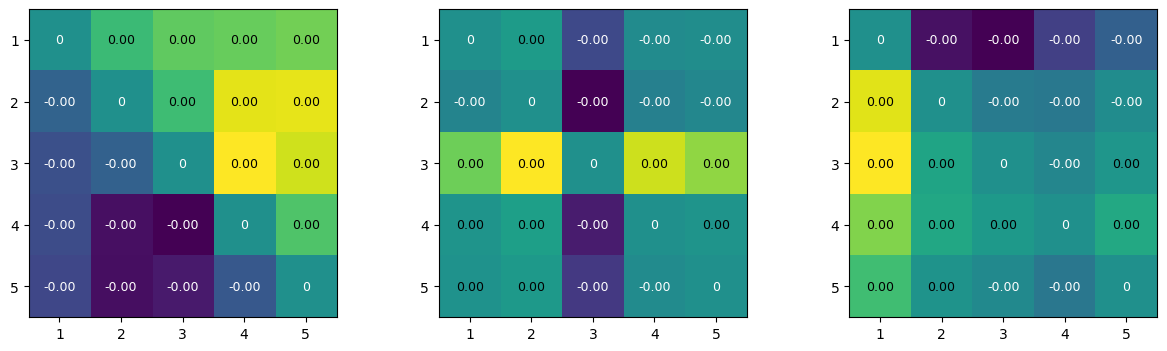